# Analisis De Textos

1. De que tratan las empresas que se estan consitituyendo? NLP en descripcion de actividades.
2. Hay algun patron geografico? (x ej con https://kepler.gl/)
3. Hay cambios a lo largo del tiempo? Algún peak interesante?
4. Qué características de empresa tienden a pedir cuenta corriente y cuáles no?
5. Cuánto tiempo pasa entre que una empresa se constituye y solicitan una cuenta corriente?
6. Podemos ver alguna red de RUTs? Gente que esta relacionada en varias empresas (quizas con https://www.graphext.com/)


In [1]:
#!pip install awswrangler
#!pip install --upgrade seaborn
#!pip install wordcloud
#!pip install --upgrade pandas
#!pip install unidecode
#!pip install gensim

In [2]:
import boto3

session = boto3.session.Session(profile_name='legalbot')
s3 = session.resource('s3')

In [3]:
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context('poster')

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8

In [4]:
bucket='legalres-storage-study-json'
prefix = 'processed'
data_location = 's3://{}/{}/'.format(bucket, prefix)

In [5]:
df = wr.s3.read_parquet(path=data_location,
                        boto3_session=session)

In [6]:
df.shape

(798060, 7)

In [7]:
df.columns

Index(['rut', 'cve', 'fecha', 'lugar', 'tipo_sociedad', 'objeto', 'firmas'], dtype='object')

In [8]:
df.head()

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas
0,76304233-2,AC1DrSkE1pdl,2013-10-08,"En TEMUCO, Región de LA ARAUCANIA, Chile, a 08...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
1,76304089-5,AC1Dv0J0V4Zr,2013-10-07,"En CONCEPCION, Región del BIOBIO, Chile, a 07 ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
2,76313238-2,AC1G6RzRn16K,2013-10-24,"En MOLINA, Región del MAULE, Chile, a 24 de oc...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
3,76313389-3,AC1G8rKdG7Xu,2013-10-24,"En COPIAPO, Región de ATACAMA, Chile, a 24 de ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
4,76313805-4,AC1H6Pt61S4o,2013-10-29,"En TALCA, Región del MAULE, Chile, a 29 de oct...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."


## Analisis de Texto 

In [18]:
TEXT_COL = 'objeto'
PROCESSED = 'objeto_processed'
SAMPLES = 30000

### Limpieza 

In [19]:
# Load the regular expression library
import re
# Remove punctuation
df[PROCESSED] = \
df[TEXT_COL].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
df[PROCESSED] = \
df[PROCESSED].map(lambda x: x.lower())
# Print out the first rows of papers
df[PROCESSED].head()

import unidecode

df[PROCESSED] = \
df[PROCESSED].map(lambda x: unidecode.unidecode(x))

Remover introduccion repetitiva

In [20]:
remove = ['la empresa tendra por objeto desarrollar las siguientes actividades:',
          'la sociedad tendra por objeto desarrollar las siguientes actividades:',
          'la actividad economica que constituira el objeto o el giro de la empresa sera :',
          'el la sociedad tiene por objeto la',
          'el objeto de la sociedad sera:',
          'objeto de la sociedad sera',
          'el objeto de la sociedad es',
          'la sociedad tendra como objeto unico',
          'prestacion de',
          'al por',
          'el objeto de la empresa sera',
          'objeto social',
          'actividad',
          'actividades',
          'cualquier otra',
          'la sociedad tiene por objeto',
          'en general',
          'clase de',
          'cuenta propia',
          'y de',
          'todo tipo',
          'toda',
          'relacionadas con',
          'clase',
          'socios',
          'podra',
          'realizar',
          'la sociedad',
          'realizacion',
          'otras'
          ]
for s in remove:
#    df[PROCESSED] = df[PROCESSED].apply(lambda x: re.sub(' ' + s + ' ', '', ' ' + x + ' '))
    s = ' ' + s + ' '
    df[PROCESSED] = [re.sub(s, ' ', ' ' + x + ' ').strip() for x in df[PROCESSED].values]

In [40]:
df.loc[df[PROCESSED].str.contains('sarollo')]

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas,objeto_processed,topic
12809,76288225-6,ACVUceUxvMgC,2013-06-04,"En INDEPENDENCIA, Región METROPOLITANA DE SANT...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,"La Sociedad tendrá por objeto desarrollar, dir...","[{'anotacion': None, 'firmado': 'Firmado elect...",tendra por objeto desarrollar directamente o p...,8
16866,76294815-K,ACKSo4So1vfr,2013-08-23,"En LA FLORIDA, Región METROPOLITANA DE SANTIAG...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",desarollo y comercializacion de software y mat...,3
17899,76294391-3,ACnv3LFKU7FV,2013-08-20,"En HUECHURABA, Región METROPOLITANA DE SANTIAG...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",desarollo de asesorias financieras tributarias...,6
32017,76439562-K,ACinqc1vb1ET,2014-11-03,"En LA SERENA, Región de COQUIMBO, Chile, a 03 ...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",el desarrollo y perfeccionamiento de proyectos...,3
32338,76441105-6,ACmyTu2JhHyq,2014-11-05,"En LAS CONDES, Región METROPOLITANA DE SANTIAG...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",investigacion teorica y desarrollo de nuevos m...,6
...,...,...,...,...,...,...,...,...,...
773932,77428306-4,ACSoCGXKVH1l,2021-08-24,"En SANTIAGO, Región METROPOLITANA DE SANTIAGO,...",SOCIEDAD POR ACCIONES,"El objeto de la sociedad será DISEÑO, FABRICAC...","[{'anotacion': None, 'firmado': 'Firmado elect...",el diseno fabricacion instalacion comercializa...,7
782545,77433374-6,ACxLk2YdCnXI,2021-08-31,"En IQUIQUE, Región de TARAPACA, Chile, a 31 de...",SOCIEDAD POR ACCIONES,El objeto de la sociedad será Consultorias y a...,"[{'anotacion': None, 'firmado': 'Firmado elect...",el consultorias y asesorias geologicas desarol...,8
787366,77445164-1,ACHo1EFGl1yq,2021-09-21,"En VALPARAISO, Región de VALPARAISO, Chile, a ...",SOCIEDAD POR ACCIONES,El objeto de la sociedad será El objeto social...,"[{'anotacion': None, 'firmado': 'Firmado elect...",el el de la empresa estar suscrito a: 1- acept...,0
788599,77434273-7,ACMqbQWnErkC,2021-09-01,"En VITACURA, Región METROPOLITANA DE SANTIAGO,...",SOCIEDAD POR ACCIONES,"El objeto de la sociedad será a) La compra, ve...","[{'anotacion': None, 'firmado': 'Firmado elect...",el a) la compra venta arriendo permuta y de to...,3


In [22]:
df.loc[12809, PROCESSED]

'tendra por objeto desarrollar directamente o por intermedio de terceros individualmente o en conjunto con otros las siguientes actividades: act empresariales profesionales prestadas a empresas ncp comercio menor no realizado en almacenes publicidad servicios informaticos venta mayor de otros productos de impresion servicios conexosdesarollo de paginas web y su mantenimientoventa de productos publicitariosventa de articulos para escuelas de conductoresdesarrollo de software'

### Word Cloud

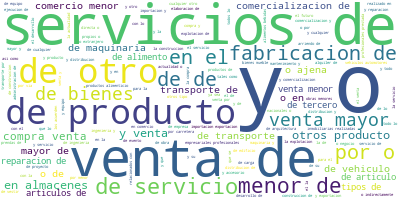

In [23]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df[PROCESSED].sample(SAMPLES).values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Tune Topic Model 

Preparar data

In [24]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words.extend(['actividades', 'venta', 'al por', 'sociedad', 'general', 'toda', 'clase', 'cualquier', 'tipo', 'desarrollo'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = df[PROCESSED].sample(SAMPLES).values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /Users/jaime/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['asesoria', 'capacitacion', 'proyectos', 'empresariales', 'industriales']


In [25]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [26]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"menor" + 0.038*"productos" + 0.029*"almacenes" + 0.028*"comercio" + '
  '0.025*"articulos" + 0.021*"servicios" + 0.021*"especializados" + '
  '0.019*"construccion" + 0.015*"mayor" + 0.015*"alimentos"'),
 (1,
  '0.021*"vehiculos" + 0.016*"transporte" + 0.014*"productos" + '
  '0.014*"servicios" + 0.011*"compra" + 0.010*"bienes" + 0.009*"distribucion" '
  '+ 0.009*"importacion" + 0.008*"accesorios" + 0.008*"automotores"'),
 (2,
  '0.039*"productos" + 0.017*"elaboracion" + 0.016*"servicios" + 0.014*"menor" '
  '+ 0.012*"mayor" + 0.010*"agricolas" + 0.010*"bienes" + 0.010*"alimentos" + '
  '0.009*"bebidas" + 0.009*"articulos"'),
 (3,
  '0.022*"servicios" + 0.016*"bienes" + 0.015*"construccion" + '
  '0.014*"ingenieria" + 0.010*"equipos" + 0.008*"sociedades" + '
  '0.008*"inversiones" + 0.008*"asesorias" + 0.007*"proyectos" + '
  '0.007*"obras"'),
 (4,
  '0.023*"productos" + 0.020*"fabricacion" + 0.019*"servicios" + '
  '0.018*"construccion" + 0.018*"obras" + 0.012*"menores" 

In [27]:
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('../reports/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself



pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '../reports/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.075699  0.002851       1        1  17.044202
8     -0.162990 -0.096014       2        1  15.412555
1      0.034261  0.020147       3        1  13.430808
3      0.119387 -0.059085       4        1  13.332633
7      0.056544 -0.031032       5        1   9.911966
0     -0.125857  0.047399       6        1   8.796871
5      0.045627 -0.001570       7        1   6.701568
2     -0.029456  0.091526       8        1   6.403355
6      0.005163  0.062022       9        1   4.985459
4     -0.018378 -0.036244      10        1   3.980583, topic_info=             Term          Freq         Total Category  logprob  loglift
200         menor   8942.000000   8942.000000  Default  30.0000  30.0000
103     productos  13035.000000  13035.000000  Default  29.0000  29.0000
208     almacenes   4022.000000   4022.000000  Default  28.0000  28.0000
263   fabricacion   6738.000000   6738.000000  Default  27.0000  27.0000
21   construccion   8264.000000   8264.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
36        muebles    142.962842   4229.102433  Topic10  -5.4090  -0.1634
19         compra    160.035108   6016.856737  Topic10  -5.2962  -0.4032
51          ajena    131.757504   3561.503136  Topic10  -5.4907  -0.0732
31     ingenieria    129.854507   3544.782437  Topic10  -5.5052  -0.0831
56      asesorias    117.496176   3278.245335  Topic10  -5.6052  -0.1049

[894 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
361       1  0.088760   abarrotes
361       2  0.036803   abarrotes
361       3  0.171025   abarrotes
361       4  0.010824   abarrotes
361       5  0.036803   abarrotes
...     ...       ...         ...
4520      1  0.070009         vta
4520      4  0.886776         vta
4520      5  0.023336         vta
9190      3  0.743582  webhosting
4519      3  0.824166     yogures

[4066 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 2, 4, 8, 1, 6, 3, 7, 5])

### Expand model to all data

In [28]:
predicted_topics = [lda_model[id2word.doc2bow(x.split())] for x in df[PROCESSED].values]

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jaime/

/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/jaime/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jaime/

In [29]:
len(predicted_topics)

798060

In [30]:
for topic, prob in predicted_topics[1]:
    print (topic, prob)

8 0.9357001


In [31]:
def find_max_topic(keypairs):
    maxprob = 0
    selected_topic = 0
    for topic, prob in keypairs:
        if prob > maxprob:
            maxprob = prob
            selected_topic = topic
    
    return selected_topic

In [32]:
selected_topics = [find_max_topic(x) for x in predicted_topics]

In [33]:
df['topic'] = selected_topics

In [34]:
df.head()

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas,objeto_processed,topic
0,76304233-2,AC1DrSkE1pdl,2013-10-08,"En TEMUCO, Región de LA ARAUCANIA, Chile, a 08...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",ejecucion de trabajos obras o servicios vincul...,7
1,76304089-5,AC1Dv0J0V4Zr,2013-10-07,"En CONCEPCION, Región del BIOBIO, Chile, a 07 ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",construccion fab de productos de madera materi...,8
2,76313238-2,AC1G6RzRn16K,2013-10-24,"En MOLINA, Región del MAULE, Chile, a 24 de oc...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",fabricacion reparacion comercializacion e impo...,1
3,76313389-3,AC1G8rKdG7Xu,2013-10-24,"En COPIAPO, Región de ATACAMA, Chile, a 24 de ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect...",servicios informaticos comercio menor no reali...,0
4,76313805-4,AC1H6Pt61S4o,2013-10-29,"En TALCA, Región del MAULE, Chile, a 29 de oct...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect...",el objeto de es: a) preparacion construccion y...,3


## Share de cada topic 

[Text(0.5, 1.0, 'Volumen de Empresas Creadas Segun Tipo de Empresa')]

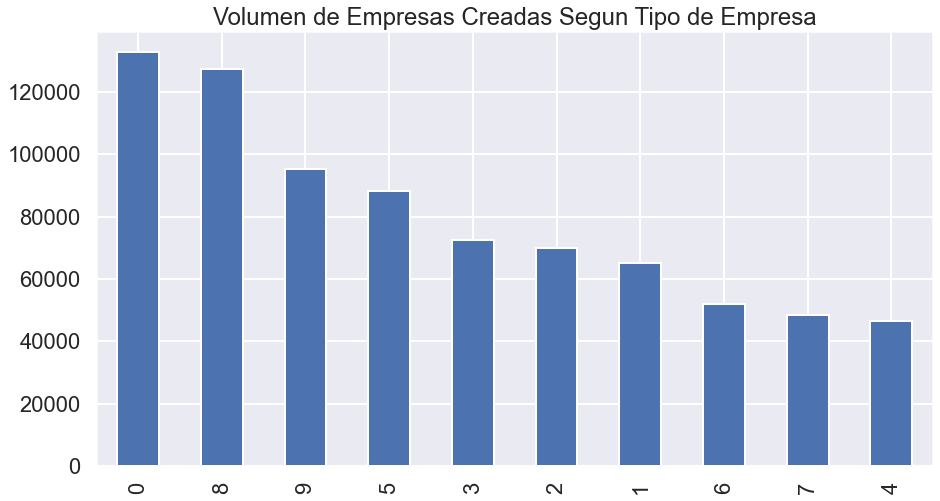

In [35]:
df['topic'].value_counts().plot.bar().set(title='Volumen de Empresas Creadas Segun Tipo de Empresa')

## Volumen de topicos over time

In [36]:
volumen = df.groupby([pd.Grouper(key='fecha', freq='m'), 'topic'])['rut'].count().unstack('topic')

In [37]:
col_order = list(df['topic'].value_counts().index)
volumen = volumen.loc[:, col_order]

[Text(0.5, 1.0, 'CONSTITUCIONES Mensuales by Tipo de Empresa')]

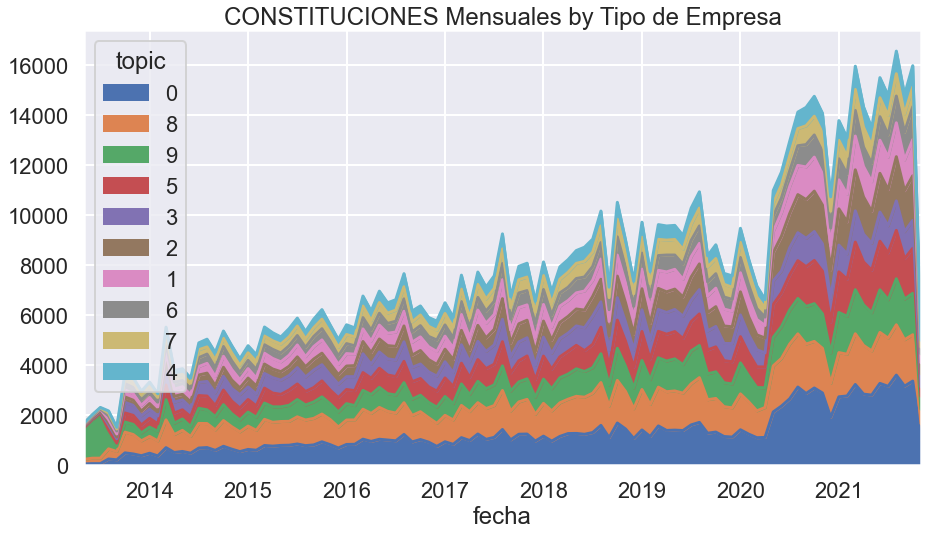

In [38]:
volumen.plot.area().set(title='CONSTITUCIONES Mensuales by Tipo de Empresa')

[Text(0.5, 1.0, '% CONSTITUCIONES Mensuales by Tipo de Empresa')]

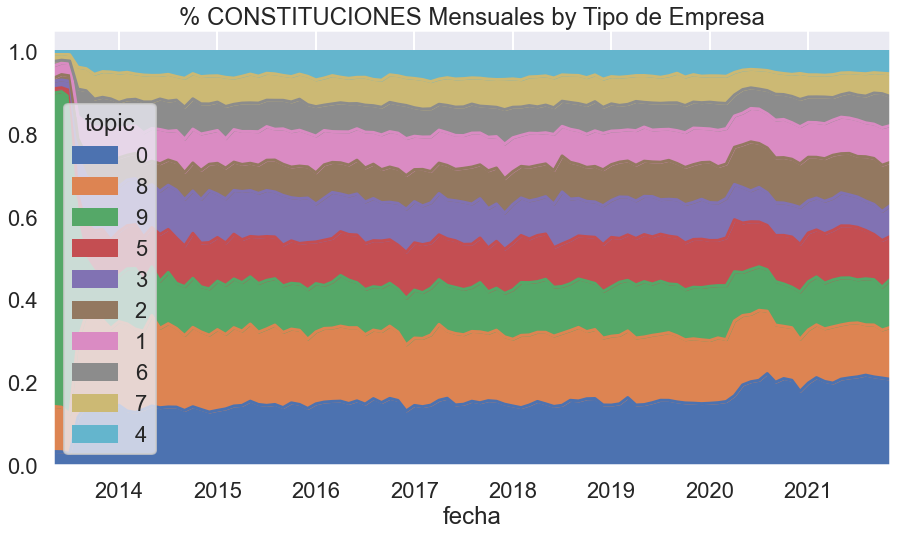

In [39]:
volumen_pct = volumen.div(volumen.sum(axis=1), axis=0)
volumen_pct.plot.area().set(title='% CONSTITUCIONES Mensuales by Tipo de Empresa')